In [1]:
%load_ext autoreload
%autoreload 2

In [9]:
import os, pickle, sys, pdb

import gym, eplus_env

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.utils.data as data

from utils import make_dict, R_func, Advantage_func, Replay_Memory, Dataset

sys.path.append('../')
from PPOLearner import PPOLearner
from PPOAgent import PPOAgent

# Setup relevant variables

#### Seed

In [10]:
SEED = 42
torch.manual_seed(SEED)

#### Create directory for saving results

In [11]:
results_dir = 'online_results'
if not os.path.exists(results_dir):
    os.mkdir(results_dir)

#### Set Names of relevant variables

In [12]:
obs_name = ["Outdoor Temp.", "Outdoor RH", "Wind Speed", "Wind Direction", "Diff. Solar Rad.", "Direct Solar Rad.", "Htg SP", "Clg SP", "Indoor Temp.", "Indoor Temp. Setpoint", "PPD", "Occupancy Flag", "Coil Power", "HVAC Power", "Sys In Temp.", "Sys In Mdot", "OA Temp.", "OA Mdot", "MA Temp.", "MA Mdot", "Sys Out Temp.", "Sys Out Mdot"]

# Modify here: Change based on the specific control problem
state_name = ["Indoor Temp."]
dist_name = ["Outdoor Temp.", "Outdoor RH", "Wind Speed", "Wind Direction", "Diff. Solar Rad.", "Direct Solar Rad.", "Occupancy Flag"]
# Caveat: The RL agent controls the difference between Supply Air Temp. and Mixed Air Temp., i.e. the amount of heating from the heating coil. But, the E+ expects Supply Air Temp. Setpoint.
ctrl_name = ["SA Temp Setpoint"]
target_name = ["Indoor Temp. Setpoint"]

#### Set Hyperparameters

In [13]:
n_state = len(state_name)
n_ctrl = len(ctrl_name)

eta = [0.1, 4] # eta: Weight for comfort during unoccupied and occupied mode
step = 300 * 3 # step: Timestep; Unit in seconds
T = 12 # T: Number of timesteps in the planning horizon
tol_eps = 90 # tol_eps: Total number of episodes; Each episode is a natural day

u_upper = 5
u_lower = 0

perf = []
multiplier = 10 # Normalize the reward for better training performance
n_step = 96     # timesteps per day

# params for training loop
gamma = 0.98
update_episode = 1

#### Load Data

In [16]:
# Read Information on Weather, Occupancy, and Target Setpoint
obs = pd.read_pickle("simulation_results/Dist-TMY3.pkl") # TODO - their example uses TMY3
target = obs[target_name]
disturbance = obs[dist_name]

# Min-Max Normalization
disturbance = (disturbance - disturbance.min())/(disturbance.max() - disturbance.min())

# Train RL Agent

Everything above this (except for the directory names) should be the same for our simulator and the EPlus gym environment used in the Gnu-RL paper. The code below this will point will have to be different between the two.

#### Load pretrained agent

In [17]:
# TODO - They aren't actually using the pre-trained agent
# From Imitation Learning
#epoch = 16
#F_hat = np.load("results/weights/F-{}.npy".format(epoch))
#Bd_hat = np.load("results/weights/Bd-{}.npy".format(epoch))

## After first round of training
F_hat = np.array([[0.9248, 0.1440]])
Bd_hat = np.array([[0.7404, 0.1490, 0.3049, 0.5458, 0.2676, 0.3085, 0.6900]])
memory = Replay_Memory()
learner = PPOLearner(memory, T, n_ctrl, n_state, target, disturbance, eta, u_upper, u_lower, 
                   F_hat = F_hat, Bd_hat = Bd_hat)

agent = PPOAgent(tol_eps, learner, multiplier, gamma, update_episode, obs_name, results_dir)

Load pretrained F
tensor([[0.9248, 0.1440]], dtype=torch.float64, requires_grad=True)
Load pretrained Bd
tensor([[0.7404, 0.1490, 0.3049, 0.5458, 0.2676, 0.3085, 0.6900]],
       dtype=torch.float64, requires_grad=True)


#### Load Gym Environment 

In [18]:
env = gym.make('5Zone-control_TMY3-v0')

#### Train the agent

In [19]:
def env_start():
    timeStep = step
    start_time = pd.datetime(year = env.start_year, month = env.start_mon, day = env.start_day)
    cur_time = start_time
    obs_dict = make_dict(obs_name, obs)
    state = torch.tensor([obs_dict[name] for name in state_name]).unsqueeze(0).double() # 1 x n_state
    observation = (state, obs_dict, obs, cur_time)
    return observation, start_time

def env_step(action, obs_dict):
    (action, SAT_stpt) = action
    timeStep, obs, isTerminal = env.step([SAT_stpt])
    obs_dict = make_dict(obs_name, obs)
    reward = R_func(obs_dict, action, eta)
    state = torch.tensor([obs_dict[name] for name in state_name]).unsqueeze(0).double()
    
    cur_time = start_time + pd.Timedelta(seconds = timeStep)
    observation = (state, obs_dict, obs, cur_time)
    
    return reward, observation, isTerminal

In [20]:
timeStep, obs, isTerminal = env.reset()
last_state, start_time = env_start()
(state, obs_dict, obs, cur_time) = last_state
# cur_time = start_time

# Save for record
timeStamp = [start_time]
observations = [obs]
actions_taken = []

"""
The agent_start, agent_end and agent_step actions work a bit differently than in a typical episodic task
This program is a continuous loop ... it doesn't really re-start an episode in the conventional way
"""
for i_episode in range(tol_eps):    
    last_action = agent.agent_start(last_state,  i_episode)
    for t in range(n_step):
        reward, last_state, term = env_step(last_action, obs_dict)

        if term or (t == (n_step-1)):
            agent.agent_end(reward, last_state, i_episode)
        else:
            last_action = agent.agent_step(reward, last_state)

[2020-09-18 14:00:55,040] EPLUS_ENV_5Zone-control-v0_MainThread_ROOT INFO:Creating EnergyPlus simulation environment...
[2020-09-18 14:00:55,048] EPLUS_ENV_5Zone-control-v0_MainThread_ROOT INFO:EnergyPlus working directory is in /Users/Gaby/Documents/uofa/hvac_control/Building_Co-simulation_Platform/gnu_rl_example/paper_example/Eplus-env-5Zone-control-v0-res1/Eplus-env-sub_run1


tensor([[0.9298, 0.1390]], dtype=torch.float64, requires_grad=True)
tensor([[0.7454, 0.1540, 0.3099, 0.5508, 0.2726, 0.3085, 0.6950]],
       dtype=torch.float64, requires_grad=True)
1991-01-02 00:00:00, reward: -2.855942578230634
tensor([[0.9347, 0.1341]], dtype=torch.float64, requires_grad=True)
tensor([[0.7498, 0.1588, 0.3148, 0.5557, 0.2776, 0.3135, 0.6999]],
       dtype=torch.float64, requires_grad=True)
1991-01-03 00:00:00, reward: -14.41348795985263
tensor([[0.9305, 0.1390]], dtype=torch.float64, requires_grad=True)
tensor([[0.7453, 0.1545, 0.3105, 0.5517, 0.2770, 0.3135, 0.6957]],
       dtype=torch.float64, requires_grad=True)
1991-01-04 00:00:00, reward: -18.499381635359818
tensor([[0.9341, 0.1386]], dtype=torch.float64, requires_grad=True)
tensor([[0.7479, 0.1571, 0.3143, 0.5556, 0.2809, 0.3182, 0.6995]],
       dtype=torch.float64, requires_grad=True)
1991-01-05 00:00:00, reward: -18.11526651311484
tensor([[0.9366, 0.1393]], dtype=torch.float64, requires_grad=True)
tensor(

tensor([[0.9283, 0.1409]], dtype=torch.float64, requires_grad=True)
tensor([[0.7401, 0.1517, 0.3082, 0.5480, 0.2765, 0.3212, 0.6944]],
       dtype=torch.float64, requires_grad=True)
1991-02-07 00:00:00, reward: -3.3044984104115867
tensor([[0.9286, 0.1407]], dtype=torch.float64, requires_grad=True)
tensor([[0.7404, 0.1520, 0.3087, 0.5485, 0.2770, 0.3234, 0.6947]],
       dtype=torch.float64, requires_grad=True)
1991-02-08 00:00:00, reward: -5.866310008383652
tensor([[0.9289, 0.1407]], dtype=torch.float64, requires_grad=True)
tensor([[0.7405, 0.1521, 0.3089, 0.5489, 0.2773, 0.3250, 0.6950]],
       dtype=torch.float64, requires_grad=True)
1991-02-09 00:00:00, reward: -12.65659387662654
tensor([[0.9286, 0.1408]], dtype=torch.float64, requires_grad=True)
tensor([[0.7402, 0.1520, 0.3084, 0.5485, 0.2770, 0.3235, 0.6947]],
       dtype=torch.float64, requires_grad=True)
1991-02-10 00:00:00, reward: -9.557502474162964
tensor([[0.9285, 0.1408]], dtype=torch.float64, requires_grad=True)
tensor(

tensor([[0.9256, 0.1362]], dtype=torch.float64, requires_grad=True)
tensor([[0.7381, 0.1496, 0.3059, 0.5446, 0.2719, 0.3197, 0.6927]],
       dtype=torch.float64, requires_grad=True)
1991-03-15 00:00:00, reward: -3.5475961002009524
tensor([[0.9256, 0.1362]], dtype=torch.float64, requires_grad=True)
tensor([[0.7381, 0.1496, 0.3059, 0.5446, 0.2719, 0.3197, 0.6927]],
       dtype=torch.float64, requires_grad=True)
1991-03-16 00:00:00, reward: -4.831028590622892
tensor([[0.9258, 0.1369]], dtype=torch.float64, requires_grad=True)
tensor([[0.7385, 0.1499, 0.3063, 0.5449, 0.2721, 0.3197, 0.6928]],
       dtype=torch.float64, requires_grad=True)
1991-03-17 00:00:00, reward: -1.772468442814023
tensor([[0.9261, 0.1369]], dtype=torch.float64, requires_grad=True)
tensor([[0.7386, 0.1501, 0.3066, 0.5450, 0.2729, 0.3200, 0.6931]],
       dtype=torch.float64, requires_grad=True)
1991-03-18 00:00:00, reward: -5.051813389598604
tensor([[0.9261, 0.1369]], dtype=torch.float64, requires_grad=True)
tensor(

# Save Results

In [15]:
obs_df = pd.DataFrame(np.array(agent.observations), index=np.array(agent.timeStamp), columns=agent.obs_name)
action_df = pd.DataFrame(np.array(agent.actions_taken), index=np.array(agent.timeStamp[:-1]),
                         columns=["Delta T", "Supply Air Temp. Setpoint"])
obs_df.to_pickle(os.path.join(results_dir, "perf_rl_obs.pkl"))
action_df.to_pickle(os.path.join(results_dir, "perf_rl_actions.pkl"))
pickle.dump(np.array(agent.perf), open(os.path.join(results_dir, "perf_rl.npy"), "wb"))

In [16]:
disturbance

,Outdoor Temp.,Outdoor RH,Wind Speed,Wind Direction,Diff. Solar Rad.,Direct Solar Rad.,Occupancy Flag
1991-01-01 00:00:00,0.391101,0.939759,0.177489,0.811189,0.000000,0.000000,0.0
1991-01-01 00:15:00,0.433255,0.942771,0.177489,0.741259,0.000000,0.000000,0.0
1991-01-01 00:30:00,0.475410,0.945783,0.177489,0.671329,0.000000,0.000000,0.0
1991-01-01 00:45:00,0.517564,0.948795,0.177489,0.601399,0.000000,0.000000,0.0
1991-01-01 01:00:00,0.559719,0.951807,0.177489,0.531469,0.000000,0.000000,0.0
1991-01-01 01:15:00,0.559719,0.951807,0.188312,0.552448,0.000000,0.000000,0.0
1991-01-01 01:30:00,0.559719,0.951807,0.199134,0.573427,0.000000,0.000000,0.0
1991-01-01 01:45:00,0.559719,0.951807,0.209957,0.594406,0.000000,0.000000,0.0
1991-01-01 02:00:00,0.559719,0.951807,0.220779,0.615385,0.000000,0.000000,0.0
1991-01-01 02:15:00,0.559719,0.951807,0.215368,0.615385,0.000000,0.000000,0.0


# Plot results

In [17]:
exp_name = 'rl'
baseline = pd.read_pickle("simulation_results/Sim-TMY3.pkl")
rl = pd.read_pickle(results_dir+"/perf_"+exp_name+"_obs.pkl")
rl_action = pd.read_pickle(results_dir+"/perf_"+exp_name+"_actions.pkl")
rl = rl.merge(rl_action, left_index = True, right_index = True)

In [18]:
def CalcStatistics(obs):
    # PPD during Occipied period
    meanPPD = np.mean(obs[obs["Occupancy Flag"]==1]["PPD"])
    print("Average PPD = ", meanPPD)
    
    CoilPower = np.sum(obs["Coil Power"]) # Unit in W
    CoilEnergy = CoilPower*900/1000/3600 # Unit in kWh
    print("Energy Consumed by the Heating Coil = {:.2f}kWh".format(CoilEnergy))
    
    HVACPower = np.sum(obs["HVAC Power"]) # Unit in W
    HVACEnergy = HVACPower*900/1000/3600 # Unit in kWh
    print("Energy Consumed by the Heating Coil = {:.2f}kWh".format(HVACEnergy))

In [19]:
print("**EnergyPlus Baseline**")
CalcStatistics(baseline)
print("**Gnu-RL**")
CalcStatistics(rl)

**EnergyPlus Baseline**
Average PPD =  17.74822905353781
Energy Consumed by the Heating Coil = 4413.17kWh
Energy Consumed by the Heating Coil = 7482.66kWh
**Gnu-RL**
Average PPD =  17.357678623539964
Energy Consumed by the Heating Coil = 3957.57kWh
Energy Consumed by the Heating Coil = 7083.61kWh


In [20]:
def plotPerf(rl, baseline, start_time, end_time):
    fig = plt.figure(figsize=(20,6))

    plt.subplot(2,1,1)
    plt.plot(baseline["Indoor Temp."], 'b-', label="EnergyPlus")
    plt.plot(rl["Indoor Temp."],'r-', label="Gnu-RL")
    plt.plot(rl["Indoor Temp. Setpoint"], 'k--')
    plt.legend()
    plt.ylabel("State\nIndoor Temp.", fontsize = 16)
    plt.xlim([start_time, end_time])

    plt.subplot(2,1,2)
    plt.plot(baseline["Sys Out Temp."],'b', label ="EnergyPlus")
    plt.plot(rl["Sys Out Temp."], 'r', label ="Gnu-RL")
    plt.plot(baseline["Occupancy Flag"]*30, 'k--', label= "Occupancy Flag")
    plt.xlim([start_time, end_time])
    plt.ylabel("Action\nSupply Air Temp.", fontsize = 16)
    plt.legend()

/Users/Gaby/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


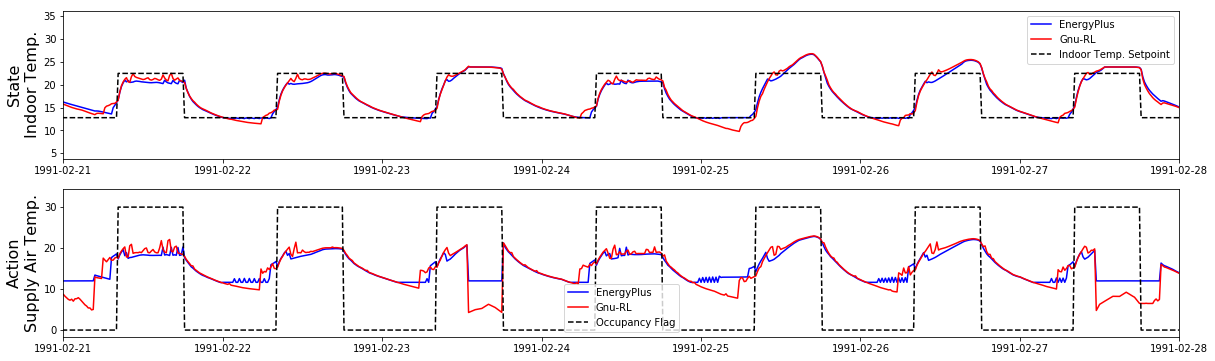

In [21]:
start_time = pd.datetime(year = 1991, month = 2, day = 21)
end_time = start_time + pd.Timedelta(days = 7)
plotPerf(rl, baseline, start_time, end_time)

# Reward

In [22]:
def CalReward(df, eta):
    df["eta"] = pd.Series([eta[int(occupied)] for occupied in df["Occupancy Flag"]], index = df.index)
    df["Reward"] = - 0.5 * df["eta"] * (df["Indoor Temp."] - df["Indoor Temp. Setpoint"])**2 - df["Delta T"]
    return df

eta = [0.1, 4]

rl = CalReward(rl, eta)

baseline["Delta T"] = baseline["Sys Out Temp."] - baseline["MA Temp."]
baseline = CalReward(baseline, eta)

In [23]:
ResReward = pd.DataFrame(rl["Reward"]-baseline["Reward"])

ResReward["Day"] = pd.Series([time.day for time in ResReward.index], index = ResReward.index)
ResReward["Month"] = pd.Series([time.month for time in ResReward.index], index = ResReward.index)
mean = ResReward.groupby(["Month", "Day"]).mean()
std = ResReward.groupby(["Month", "Day"]).std()

index = pd.date_range(start='1/1/2017', end='3/31/2017')
RewardStats = pd.DataFrame(np.concatenate([mean.values[:90], std.values[:90]], axis =1), index = index, columns = ["Mean", "Std"])

Text(0,0.5,'Residue Reward')

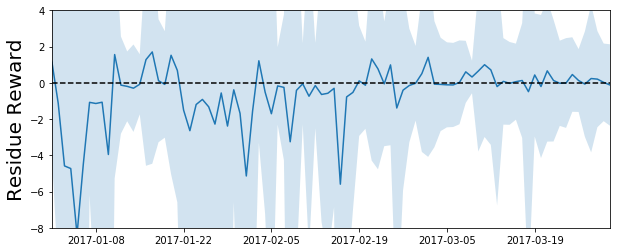

In [24]:
fig = plt.figure(figsize=(10, 4))

start_time = pd.datetime(year = 2017, month = 1, day = 1)
end_time =pd.datetime(year = 2017, month = 3, day = 31)

plt.plot(RewardStats["Mean"])
plt.fill_between(RewardStats.index, RewardStats["Mean"]-1.645*RewardStats["Std"], RewardStats["Mean"]+1.645*RewardStats["Std"], alpha = 0.2)

plt.plot((start_time, end_time), (0, 0), 'k--')

plt.xlim((start_time, end_time))
plt.ylim((-8, 4))

plt.ylabel("Residue Reward", fontsize = 20)